# Capstone Project

## Overview
This notebook runs the Day 15 capstone simulator: an e-commerce model-routing optimizer
using contextual bandits (LinUCB, Thompson Sampling, and epsilon-greedy) trained on
delayed conversion feedback with a simple safety gate. We evaluate actual
conversion/profit and estimate policy value offline using Doubly Robust OPE.


**Objective:** Synthesize everything you've learned by designing and implementing a mini version of Sqwish's optimization engine. This capstone project will have you create a simulated environment and then build an agent that optimizes in that environment, incorporating bandits, delayed rewards, safety checks, and evaluation in one end-to-end prototype.

**Project Brief:** *E-commerce Model Router.* You will simulate an e-commerce website where a model is chosen to generate product descriptions (generation is abstracted away), and the goal is to maximize conversion (purchase) while respecting cost. Three different models (of varying cost and quality) are available. Users have different preferences. You'll build a contextual bandit agent to route the models optimally.

**Environment Setup:**

- **User Context:** Define a user persona feature (e.g. budget_sensitive vs quality_seeker) and a product category feature. These together form the context $x$.
- **Arms/Actions:** Three model choices for generating the description: *Model A* (cheap & concise), *Model B* (moderate), *Model C* (expensive & detailed). You can also allow the prompt to vary or other actions, but at minimum choosing the model is the action.
- **Hidden Reward Function:** Simulate probability of conversion as a function of context and model. For example: budget_sensitive users convert better with concise Model A (perhaps they don't like fluff), quality_seekers convert better with detailed Model C. You can fabricate this mapping, e.g., P(buy | x, A) = 0.05 normally, but 0.15 if user is budget_sensitive; P(buy | x, C) = 0.05 normally, but 0.15 if user is quality_seeker, etc. The idea is each model is optimal for a certain segment. Conversion is binary (success/fail).
- **Cost Model:** Assign a "cost" to using each model (e.g. A costs $0.01, B $0.02, C $0.10 per description). This will be used in evaluating the profit.

**Agent Requirements:**

- Use a **Contextual Bandit algorithm** (Thompson Sampling or LinUCB recommended) to learn over interactions which model works best for which context. The agent will make a choice each round (given context, pick model) and observe a stochastic conversion after a delay.
- **Delayed Feedback:** Assume conversions are observed after a delay. Update the bandit when the real conversion arrives, using profit (conversion value minus cost) as the reward.
- **Off-Policy Evaluation:** Before fully trusting your learned policy, use an offline evaluation. For example, have the agent do an initial random policy for 1000 interactions to gather a log. Then when your bandit policy is learned, use **IPS or Doubly Robust** on that log to estimate the conversion rate of the bandit policy *without* deploying it. Compare this estimate to the actual performance when you do run the bandit live in the simulator. This checks your OPE integration.
- **Safety Constraint:** Implement a simple safety rule in the simulator (for instance, Model C might occasionally produce an unsafe word). If that happens, the user instantly doesn't buy and is unhappy. Ensure your agent either learns to avoid that or you add a filter. (This can be simulated by saying: with small probability, Model C outputs something disallowed, which always results in no conversion; the agent could learn that risk or you can explicitly penalize it.)


###  Short simualtion for sanity check

###  Long simualtion check



linucb:
  DR conversion estimate: 0.6487
  DR profit estimate:     0.6102
  Eval conversion:        0.6550
  Eval profit:            0.6147
  Eval unsafe rate:       0.0050

thompson:
  DR conversion estimate: 0.6718
  DR profit estimate:     0.6244
  Eval conversion:        0.6640
  Eval profit:            0.6196
  Eval unsafe rate:       0.0070

epsilon_greedy:
  DR conversion estimate: 0.6377
  DR profit estimate:     0.5998
  Eval conversion:        0.6430
  Eval profit:            0.6049
  Eval unsafe rate:       0.0110


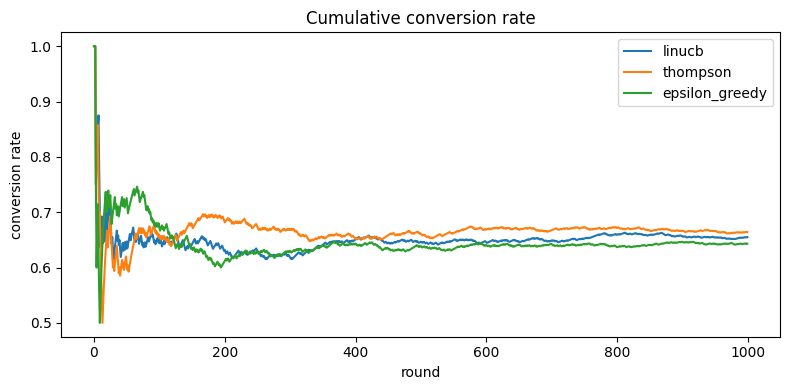

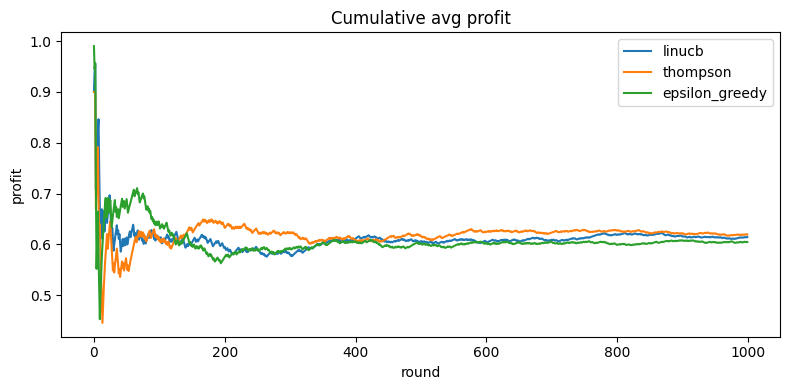

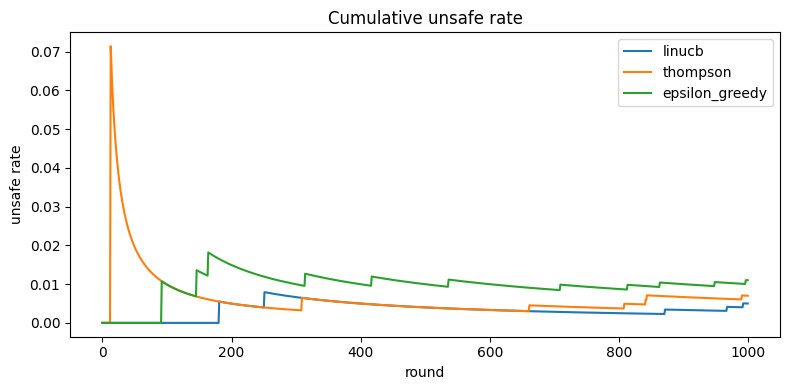

<Figure size 640x480 with 0 Axes>

In [2]:
%matplotlib inline
%run run.py --rounds 5000 --log-rounds 1000 --eval-rounds 1000

## Implementation Notes

### Goals
- Compare three bandit policies: LinUCB, Thompson Sampling, and epsilon-greedy.
- Train on delayed conversion feedback with a safety gate and costs.
- Estimate offline value with Doubly Robust OPE and compare to actual.

### Design Choices
- Context: continuous embedding (dim=8) plus categorical persona/category features.
- Delay model: exponential delay (mean=50) to mimic long-tail conversions.
- Safety: Model C has 2% unsafe injection; unsafe always yields no conversion.
- Costs/value: A/B/C costs = 0.01/0.02/0.10, conversion value = 1.0.
- OPE: Doubly Robust using logistic regression for conversion probability.

### Code Layout
- `Day_15/sim.py`: environment, contexts, conversion model, delay, costs, safety.
- `Day_15/agents.py`: LinUCB (imported), Thompson Sampling, epsilon-greedy, block features.
- `Day_15/ope.py`: DR estimator + logistic regression reward model.
- `Day_15/run.py`: end-to-end training, OPE, evaluation, plots.

### How the Run Works
1) Log N random interactions for OPE.
2) Train each agent for the remaining rounds using delayed profit feedback (conversion value minus cost).
3) Evaluate each learned policy on fresh rounds (actual conversion + profit).
4) Use DR OPE on the log to estimate conversion/profit and compare to actual.


### Context + Preference Modeling
- Each round samples a context with: (1) an 8-dim continuous embedding `embed`, (2) a persona id `persona`, and (3) a category id `category`.
- `embed` is a synthetic latent feature vector; `embed_w` contains per-model weights that score those features.
- `persona_aff` is a lookup table: `persona_aff[persona, a]` adds a persona-specific bias for model `a`.
- `category_aff` is a lookup table: `category_aff[category, a]` adds a category-specific bias for model `a`.
- For each model/arm `a`, we compute a logit score $s_a = base[a] + embed_w[a]^T\,embed + persona_aff[persona, a] + category_aff[category, a]$.
- Conversion probability is $P(\text{convert}\mid x,a)=\sigma(s_a)$.


### Data Labels + Delayed Feedback
- Labels used in the simulator are defined in `Day_15/sim.py`: `PERSONA_NAMES`, `CATEGORY_NAMES`, and `MODEL_NAMES`.
- Unsafe events are injected for Model C with probability `unsafe_rate`; unsafe always yields no conversion.
- True conversion is delayed: when an action is taken at time $t$, its conversion outcome is delivered at $t + d$ with d ~ Exponential(mean=50).
- During training, we update the bandit when the conversion arrives, using profit (conversion value minus cost).


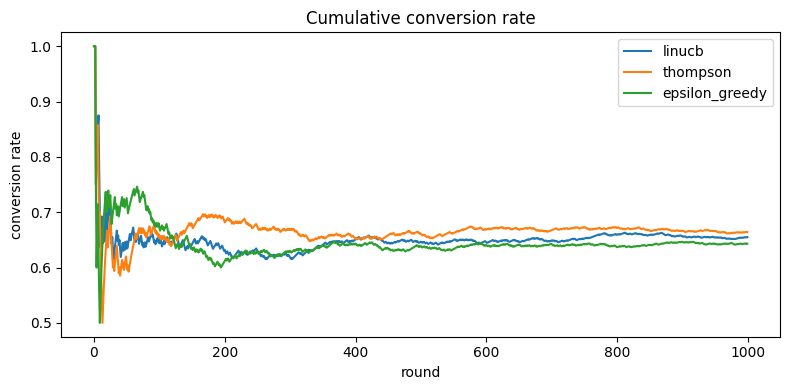

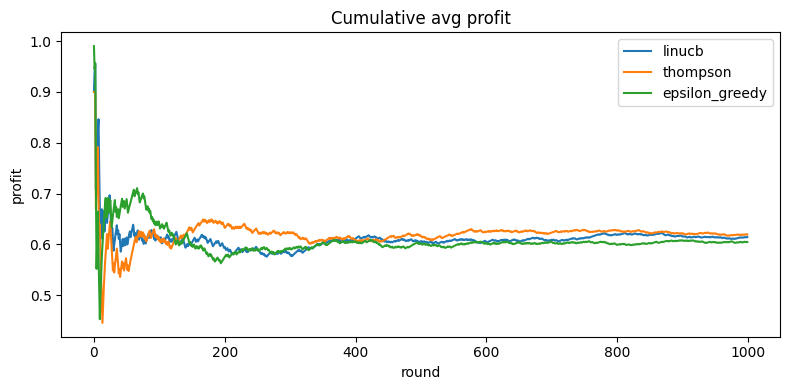

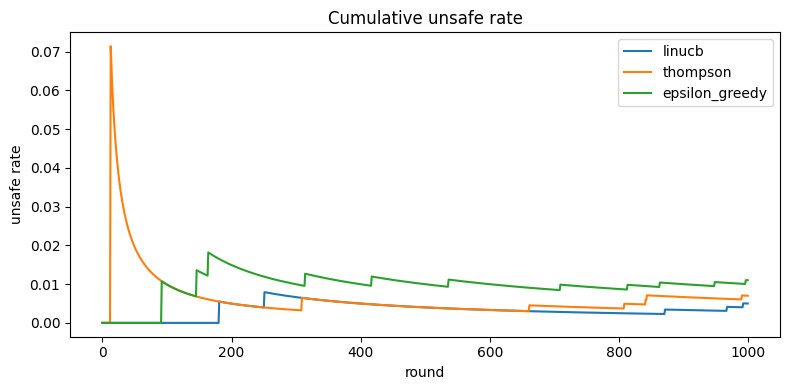

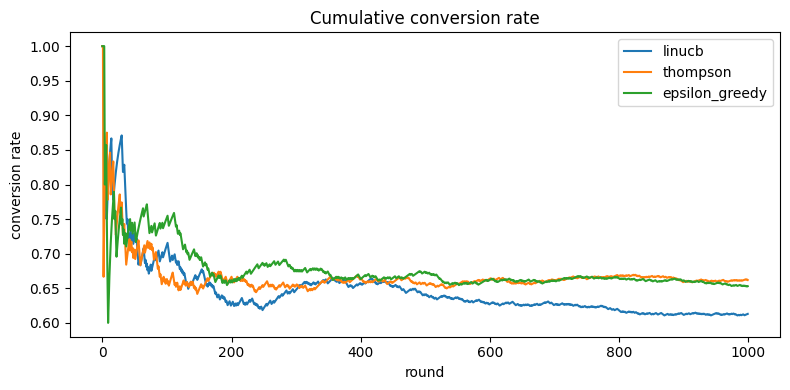

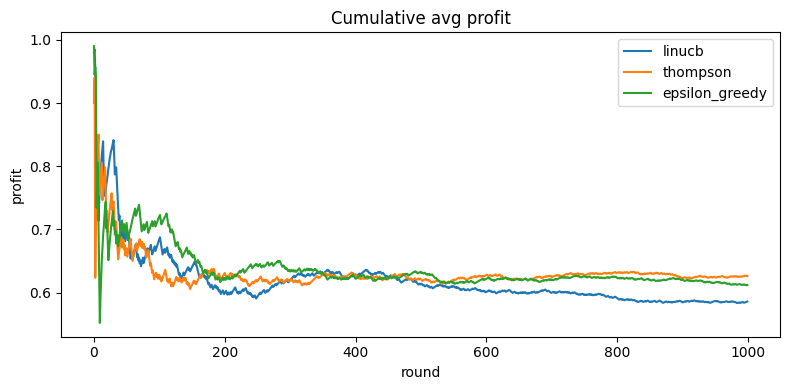

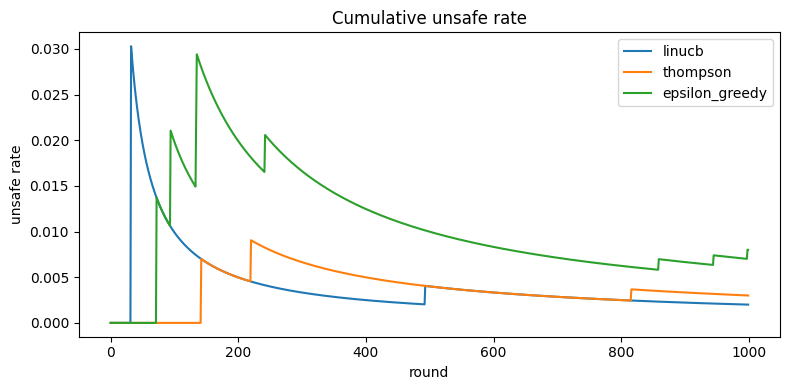

Per-strategy head-to-head (delay=50 vs no delay=0)

linucb
metric         delay=50   no_delay=0
------------------------------------
DR conv           0.649        0.660
DR profit         0.610        0.633
Eval conv         0.655        0.613
Eval profit       0.615        0.586
Eval unsafe       0.005        0.002

thompson
metric         delay=50   no_delay=0
------------------------------------
DR conv           0.672        0.678
DR profit         0.624        0.641
Eval conv         0.664        0.662
Eval profit       0.620        0.626
Eval unsafe       0.007        0.003

epsilon_greedy
metric         delay=50   no_delay=0
------------------------------------
DR conv           0.638        0.696
DR profit         0.600        0.653
Eval conv         0.643        0.653
Eval profit       0.605        0.612
Eval unsafe       0.011        0.008


In [8]:
# Compare delayed feedback vs no delay
from pathlib import Path
import sys

here = Path.cwd()
if (here / 'run.py').exists():
    sys.path.insert(0, str(here.parent))
else:
    sys.path.insert(0, str(here))

from Day_15 import run

base_kwargs = dict(rounds=5000, log_rounds=1000, eval_rounds=1000, seed=0, epsilon=0.1,
                   plot=True)

summary_delay, _ = run.run_experiment(delay_mean=50.0, **base_kwargs)
summary_nodelay, _ = run.run_experiment(delay_mean=0.0, **base_kwargs)

print("Per-strategy head-to-head (delay=50 vs no delay=0)")

for name in summary_delay.keys():
    d = summary_delay[name]
    n = summary_nodelay[name]
    print("")
    print(name)
    header = f"{'metric':<12} {'delay=50':>10} {'no_delay=0':>12}"
    print(header)
    print("-" * len(header))
    rows = [
        ("DR conv", d.dr_conversion, n.dr_conversion),
        ("DR profit", d.dr_profit, n.dr_profit),
        ("Eval conv", d.actual_conversion, n.actual_conversion),
        ("Eval profit", d.actual_profit, n.actual_profit),
        ("Eval unsafe", d.actual_unsafe, n.actual_unsafe),
    ]
    for label, dv, nv in rows:
        print(f"{label:<12} {dv:>10.3f} {nv:>12.3f}")


### Delay Setting Note
- `delay_mean = 0` means no delay: conversion outcomes are applied immediately, and training uses the real conversion reward.
- `delay_mean > 0` uses an exponential delay with that mean; training updates only when conversions arrive.
- Evaluation uses immediate conversions (no delay) for a clean readout.


In [9]:
# Average over multiple seeds
from pathlib import Path
import sys

import numpy as np

here = Path.cwd()
if (here / 'run.py').exists():
    sys.path.insert(0, str(here.parent))
else:
    sys.path.insert(0, str(here))

from Day_15 import run

base_kwargs = dict(rounds=5000, log_rounds=1000, eval_rounds=1000, epsilon=0.1,
                   plot=False)

seeds = list(range(10))
metrics = [
    ('DR conv', 'dr_conversion'),
    ('DR profit', 'dr_profit'),
    ('Eval conv', 'actual_conversion'),
    ('Eval profit', 'actual_profit'),
    ('Eval unsafe', 'actual_unsafe'),
]

summary_delay, _ = run.run_experiment(delay_mean=50.0, seed=seeds[0], **base_kwargs)
strategies = list(summary_delay.keys())
results = {
    name: {metric: {'delay': [], 'nodelay': []} for _, metric in metrics}
    for name in strategies
}

for seed in seeds:
    summary_delay, _ = run.run_experiment(delay_mean=50.0, seed=seed, **base_kwargs)
    summary_nodelay, _ = run.run_experiment(delay_mean=0.0, seed=seed, **base_kwargs)
    for name in strategies:
        d = summary_delay[name]
        n = summary_nodelay[name]
        for _, metric in metrics:
            results[name][metric]['delay'].append(getattr(d, metric))
            results[name][metric]['nodelay'].append(getattr(n, metric))

print(f"Average over {len(seeds)} seeds (delay=50 vs no delay=0)")

for name in strategies:
    print("")
    print(name)
    header =  (
        f"{'metric':<12} {'delay=50 mean':>14} {'delay=50 std':>13} "
        f"{'no_delay mean':>14} {'no_delay std':>13}"
    )
    print(header)
    print("-" * len(header))
    for label, metric in metrics:
        d_vals = np.asarray(results[name][metric]['delay'], dtype=float)
        n_vals = np.asarray(results[name][metric]['nodelay'], dtype=float)
        print(
            f"{label:<12} {d_vals.mean():>14.3f} {d_vals.std(ddof=1):>13.3f} "
            f"{n_vals.mean():>14.3f} {n_vals.std(ddof=1):>13.3f}"
        )


Average over 10 seeds (delay=50 vs no delay=0)

linucb
metric        delay=50 mean  delay=50 std  no_delay mean  no_delay std
----------------------------------------------------------------------
DR conv               0.655         0.031          0.650         0.028
DR profit             0.616         0.032          0.613         0.028
Eval conv             0.661         0.023          0.656         0.020
Eval profit           0.622         0.023          0.619         0.018
Eval unsafe           0.006         0.002          0.005         0.003

thompson
metric        delay=50 mean  delay=50 std  no_delay mean  no_delay std
----------------------------------------------------------------------
DR conv               0.655         0.021          0.656         0.022
DR profit             0.614         0.022          0.616         0.023
Eval conv             0.652         0.021          0.653         0.014
Eval profit           0.611         0.019          0.614         0.015
Eval unsafe 